In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import classeval
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

# Data reading

In [2]:
df_f = pd.read_csv('feat.csv', na_values=[' ?'], error_bad_lines=False)
df_f.head()

,participantN,age,gender,trialN,task,condition,FeatConj,setSize,proportion,timelimit,...,group_same,group_switch,strict_line,blocked_grouped,ratio,run_length,cl_same,cl_other,cl_blue,cl_yellow
0,1,0,,1,0,r/g,0,80,50,0.0,...,0,0,0,0,-0.043466,0.0,46.307892,130.180474,95.377290,123.727589
1,1,0,,1,0,r/g,0,80,50,0.0,...,0,0,1,0,-0.066947,1.0,126.127896,67.599712,65.038921,146.307241
2,1,0,,1,0,r/g,0,80,50,0.0,...,0,0,0,0,0.066947,2.0,128.727980,92.588600,51.182460,197.918981
3,1,0,,1,0,r/g,0,80,50,0.0,...,0,0,0,0,0.045757,0.0,128.727980,50.406248,100.312921,96.387240
4,1,0,,1,0,r/g,0,80,50,0.0,...,0,0,1,0,-0.048305,1.0,236.606173,50.406248,115.722899,70.010926


In [3]:
df_c = pd.read_csv('conj.csv', na_values=[' ?'])
df_c.head()

,participantN,age,gender,trialN,task,condition,FeatConj,setSize,proportion,timelimit,...,grouping_same,grouping_switch,strict_line,blocked_grouped,ratio,run_length,cl_same,cl_other,cl_same_color,cl_same_shape
0,1,0,,0,0,rs/gd,1,80,50,0.0,...,0,0,0,0,-0.043466,0.0,72.458664,120.597315,173.653234,44.679822
1,1,0,,0,0,rs/gd,1,80,50,0.0,...,0,0,0,0,-0.066947,1.0,72.458664,182.400411,234.405408,83.775601
2,1,0,,0,0,rs/gd,1,80,50,0.0,...,0,0,0,0,-0.091770,2.0,73.795082,76.746862,82.512947,105.839343
3,1,0,,0,0,rs/gd,1,80,50,0.0,...,0,0,0,0,-0.118099,3.0,73.795082,103.951828,148.780161,58.197959
4,1,0,,0,0,rs/gd,1,80,50,0.0,...,0,0,0,0,-0.146128,4.0,73.427475,111.076559,194.010000,142.506925


In [4]:
df_f.describe()

,participantN,age,trialN,task,FeatConj,setSize,proportion,timelimit,timeTS,timeRel,...,group_same,group_switch,strict_line,blocked_grouped,ratio,run_length,cl_same,cl_other,cl_blue,cl_yellow
count,12870.000000,12870.000000,12870.000000,12870.0,12870.0,12870.0,12870.0,12870.0,12870.000000,12870.000000,...,12870.000000,12870.000000,12870.000000,12870.0,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000,12870.000000
mean,56.424242,1.454545,5.027273,0.0,0.0,80.0,50.0,0.0,9677.775236,361.257980,...,1.326496,1.037451,0.044911,0.0,0.064201,2.691531,105.528243,98.016011,99.374017,98.937248
std,57.187211,5.774204,3.206536,0.0,0.0,0.0,0.0,0.0,8359.550436,408.490427,...,1.546946,1.306479,0.207116,0.0,0.363407,3.956121,44.740377,38.912214,40.410164,39.506846
min,1.000000,0.000000,0.000000,0.0,0.0,80.0,50.0,0.0,660.183458,99.307000,...,0.000000,0.000000,0.000000,0.0,-1.322219,0.000000,7.641217,4.293483,5.877933,9.577233
25%,9.000000,0.000000,2.000000,0.0,0.0,80.0,50.0,0.0,4709.145292,249.302979,...,0.000000,0.000000,0.000000,0.0,-0.091770,0.000000,73.970992,71.149950,71.827454,71.957130
50%,17.000000,0.000000,5.000000,0.0,0.0,80.0,50.0,0.0,8408.941917,316.416271,...,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,94.645416,89.083073,90.015061,89.791998
75%,125.000000,0.000000,8.000000,0.0,0.0,80.0,50.0,0.0,12309.683667,416.761729,...,3.000000,2.000000,0.000000,0.0,0.134699,3.000000,127.339915,115.658873,117.181983,115.636209
max,133.000000,27.000000,14.000000,0.0,0.0,80.0,50.0,0.0,82793.777083,40668.799167,...,7.000000,7.000000,1.000000,0.0,1.322219,19.000000,377.035174,336.753693,393.269275,374.578924


In [5]:
df_c.describe()

,participantN,age,trialN,task,FeatConj,setSize,proportion,timelimit,timeTS,timeRel,...,grouping_same,grouping_switch,strict_line,blocked_grouped,ratio,run_length,cl_same,cl_other,cl_same_color,cl_same_shape
count,12831.000000,12831.000000,12831.000000,12831.0,12831.0,12831.0,12831.0,12831.0,12831.000000,12831.000000,...,12831.000000,12831.000000,12831.000000,12831.0,12831.000000,12831.000000,12831.000000,12831.000000,12831.000000,12831.000000
mean,56.537994,1.458967,5.911854,0.0,1.0,80.0,50.0,0.0,11298.114532,466.628504,...,1.305978,1.015042,0.040917,0.0,0.179324,7.804458,105.513491,99.434963,99.223267,99.130805
std,57.236771,5.782416,3.580924,0.0,0.0,0.0,0.0,0.0,8331.539842,558.978566,...,1.538357,1.290897,0.198105,0.0,0.642546,5.721589,44.230939,40.501896,40.004760,39.473739
min,1.000000,0.000000,0.000000,0.0,1.0,80.0,50.0,0.0,640.156167,83.092667,...,0.000000,0.000000,0.000000,0.0,-1.322219,0.000000,32.318157,32.886681,32.340570,30.692352
25%,9.000000,0.000000,3.000000,0.0,1.0,80.0,50.0,0.0,5507.323917,265.987062,...,0.000000,0.000000,0.000000,0.0,-0.243038,3.000000,74.458502,71.652565,72.058006,72.259452
50%,17.000000,0.000000,6.000000,0.0,1.0,80.0,50.0,0.0,10177.088958,350.212583,...,0.000000,0.000000,0.000000,0.0,0.000000,7.000000,94.292463,90.074732,89.736319,90.146002
75%,125.000000,0.000000,9.000000,0.0,1.0,80.0,50.0,0.0,14874.375750,500.020083,...,3.000000,2.000000,0.000000,0.0,0.778151,13.000000,125.926552,116.545651,116.395681,115.647912
max,133.000000,27.000000,15.000000,0.0,1.0,80.0,50.0,0.0,79145.674583,20817.914875,...,7.000000,6.000000,1.000000,0.0,1.301030,19.000000,403.199657,457.292279,477.650534,411.250352


# Data preprocessing

#### Drop unuseful columns

In [6]:
df_f.columns = df_f.columns.str.strip()
for column in df_f.columns.values:
    if df_f[column].dtype == 'object':
        df_f[column] = df_f[column].str.strip()
df_f.columns.values

array(['participantN', 'age', 'gender', 'trialN', 'task', 'condition',
       'FeatConj', 'setSize', 'proportion', 'timelimit', 'stType',
       'imgName', 'timeTS', 'timeRel', 'runLength', 'runTest', 'touchTS',
       'runN', 'runNH', 'stPosX', 'stPosY', 'col', 'row', 'touchX',
       'touchY', 'touchDist', 'targDist', 'touchN', 'error', 'switches',
       'changeScreen', 'resp_pos', 'group_selected', 'group_same',
       'group_switch', 'strict_line', 'blocked_grouped', 'ratio',
       'run_length', 'cl_same', 'cl_other', 'cl_blue', 'cl_yellow'],
      dtype=object)

In [7]:
df_c.columns = df_c.columns.str.strip()
for column in df_c.columns.values:
    if df_c[column].dtype == 'object':
        df_c[column] = df_c[column].str.strip()
df_c.columns.values

array(['participantN', 'age', 'gender', 'trialN', 'task', 'condition',
       'FeatConj', 'setSize', 'proportion', 'timelimit', 'stType',
       'imgName', 'timeTS', 'timeRel', 'runLength', 'runTest', 'touchTS',
       'runN', 'runNH', 'stPosX', 'stPosY', 'col', 'row', 'touchX',
       'touchY', 'touchDist', 'targDist', 'touchN', 'error', 'switches',
       'changeScreen', 'resp_pos', 'grouping_selected', 'grouping_same',
       'grouping_switch', 'strict_line', 'blocked_grouped', 'ratio',
       'run_length', 'cl_same', 'cl_other', 'cl_same_color',
       'cl_same_shape'], dtype=object)

In [8]:
useless_features = ['participantN', 'age', 'gender', 'trialN', 'task', 'condition',
                    'FeatConj', 'setSize', 'proportion', 'timelimit', 'stType',
                    'imgName', 'timeTS', 'timeRel', 'runLength', 'runTest', 
                    'touchTS','runN', 'runNH', 'stPosX', 'stPosY', 'col', 
                    'row', 'touchX', 'touchY', 'touchDist', 'touchN', 'error',
                    'changeScreen', 'resp_pos']
df_f.drop(columns=useless_features, inplace=True)
df_f.columns.values

array(['targDist', 'switches', 'group_selected', 'group_same',
       'group_switch', 'strict_line', 'blocked_grouped', 'ratio',
       'run_length', 'cl_same', 'cl_other', 'cl_blue', 'cl_yellow'],
      dtype=object)

In [9]:
df_c.drop(columns=useless_features, inplace=True)
df_c.columns.values

array(['targDist', 'switches', 'grouping_selected', 'grouping_same',
       'grouping_switch', 'strict_line', 'blocked_grouped', 'ratio',
       'run_length', 'cl_same', 'cl_other', 'cl_same_color',
       'cl_same_shape'], dtype=object)

#### Record parameters and predicted parameter

In [10]:
variables_names_f = df_f.columns.values
target_variable_f = variables_names_f[1]
feature_variables_f = np.delete(variables_names_f, [1])

In [11]:
variables_names_c = df_c.columns.values
target_variable_c = variables_names_c[1]
feature_variables_c = np.delete(variables_names_c, [1])

## Train_feat

In [12]:
X = df_f
y = df_f['switches'].to_numpy()

In [13]:
train_f, test_f, y_train_f, y_test_f = train_test_split(X, y ,test_size=0.2,random_state=42)

## Train_conj

In [17]:
X = df_c
y = df_c['switches']

In [18]:
train_c, test_c, y_train_c, y_test_c = train_test_split(X, y, test_size=0.2,random_state=42)

## Feature MultinomalNB

[classeval] AUC: 1.00
[classeval] F1: 1.00
[classeval] Kappa: 1.00
[classeval] MCC score: 1.00
[classeval] Average precision (AP): 1.00
[classeval] CAP: 806
Accuracy Score is  1.0
Avg accuracy: 1.0


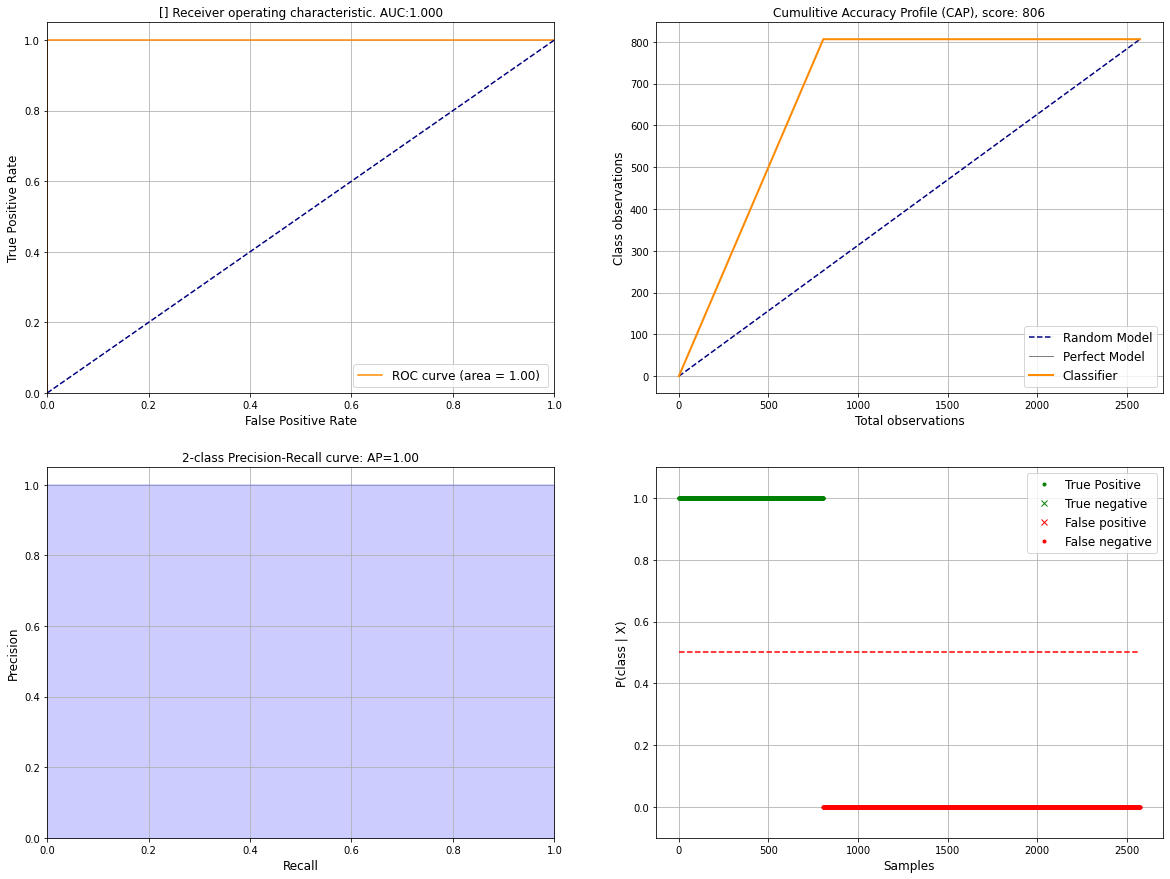

array([[<AxesSubplot:title={'center':'[] Receiver operating characteristic. AUC:1.000'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
        <AxesSubplot:title={'center':'Cumulitive Accuracy Profile (CAP), score: 806'}, xlabel='Total observations', ylabel='Class observations'>],
       [<AxesSubplot:title={'center':'2-class Precision-Recall curve: AP=1.00'}, xlabel='Recall', ylabel='Precision'>,
        <AxesSubplot:xlabel='Samples', ylabel='P(class | X)'>]],
      dtype=object)

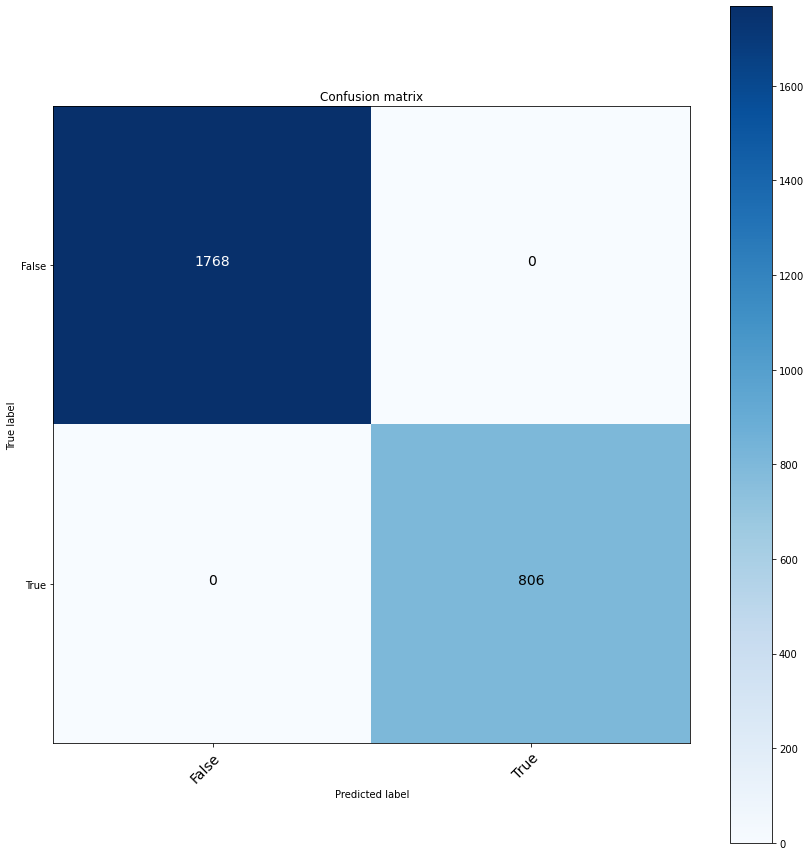

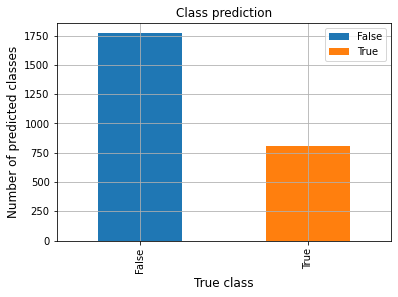

In [23]:
from sklearn.naive_bayes import BernoulliNB
model_f = BernoulliNB()
model_f.fit(train_f, y_train_f)

# Predict Output
y_pred_f = model_f.predict(test_f)
y_proba = model_f.predict_proba(test_f)
k = 10
kf = KFold(n_splits=k, random_state=None)
# Evaluate results
result = cross_val_score(model_f , X, y, cv = kf)
results = classeval.eval(y_test_f.astype(bool), y_pred_f.astype(bool), y_proba[:,0])
print("Accuracy Score is ", model_f.score(train_f, y_train_f))
print("Avg accuracy: {}".format(result.mean()))
classeval.plot(results)


In [24]:
conf_mat = metrics.confusion_matrix(y_pred_f, y_test_f)
print('Accuracy state 1:', conf_mat[0, 0] / conf_mat[0, 1] * 100)
print('Accuracy state 0:', conf_mat[1, 0] / conf_mat[1, 1] * 100)

Accuracy state 1: inf
Accuracy state 0: 0.0


<ipython-input-24-cd63641a462b>:2: RuntimeWarning: divide by zero encountered in longlong_scalars
  print('Accuracy state 1:', conf_mat[0, 0] / conf_mat[0, 1] * 100)


## conjunctuin MultinomalNB

[classeval] AUC: 1.00
[classeval] F1: 1.00
[classeval] Kappa: 1.00
[classeval] MCC score: 1.00
[classeval] Average precision (AP): 1.00
[classeval] CAP: 201
Accuracy Score is  1.0
Avg accuracy: 1.0


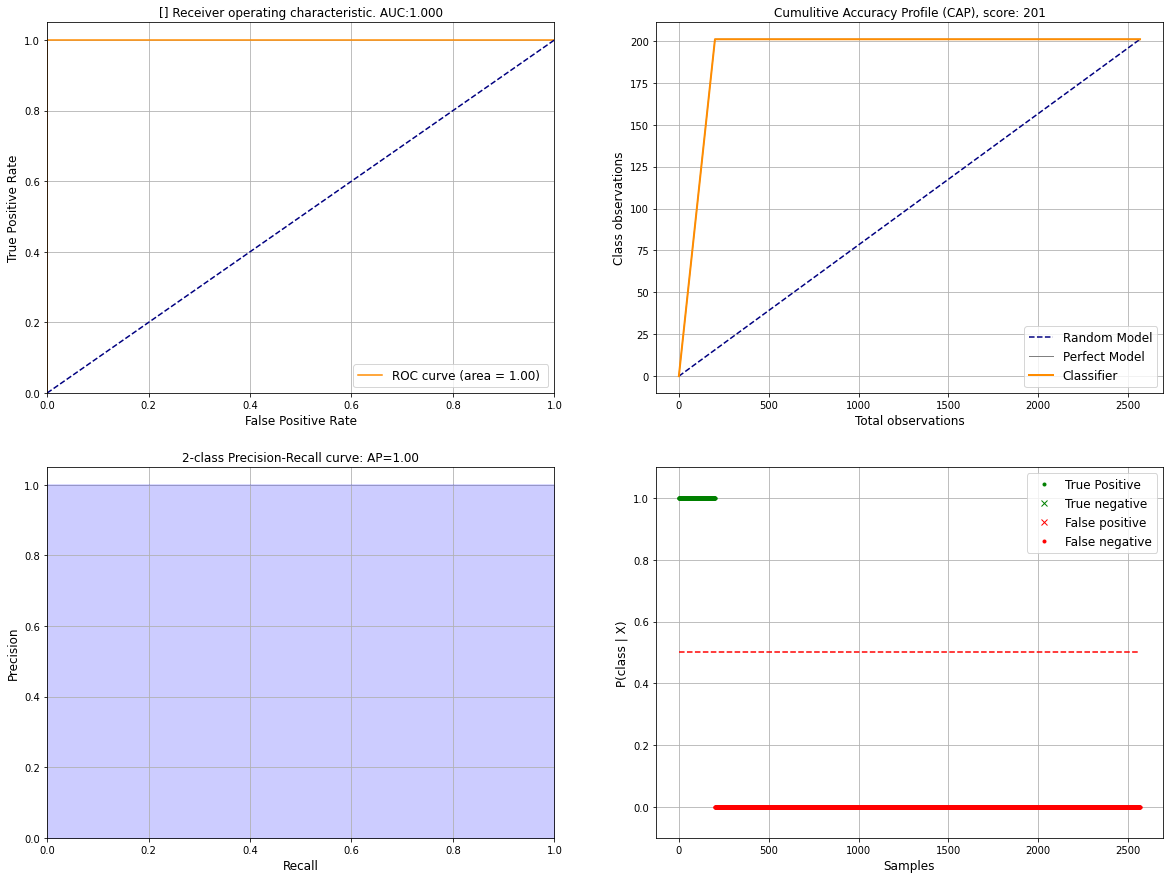

array([[<AxesSubplot:title={'center':'[] Receiver operating characteristic. AUC:1.000'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
        <AxesSubplot:title={'center':'Cumulitive Accuracy Profile (CAP), score: 201'}, xlabel='Total observations', ylabel='Class observations'>],
       [<AxesSubplot:title={'center':'2-class Precision-Recall curve: AP=1.00'}, xlabel='Recall', ylabel='Precision'>,
        <AxesSubplot:xlabel='Samples', ylabel='P(class | X)'>]],
      dtype=object)

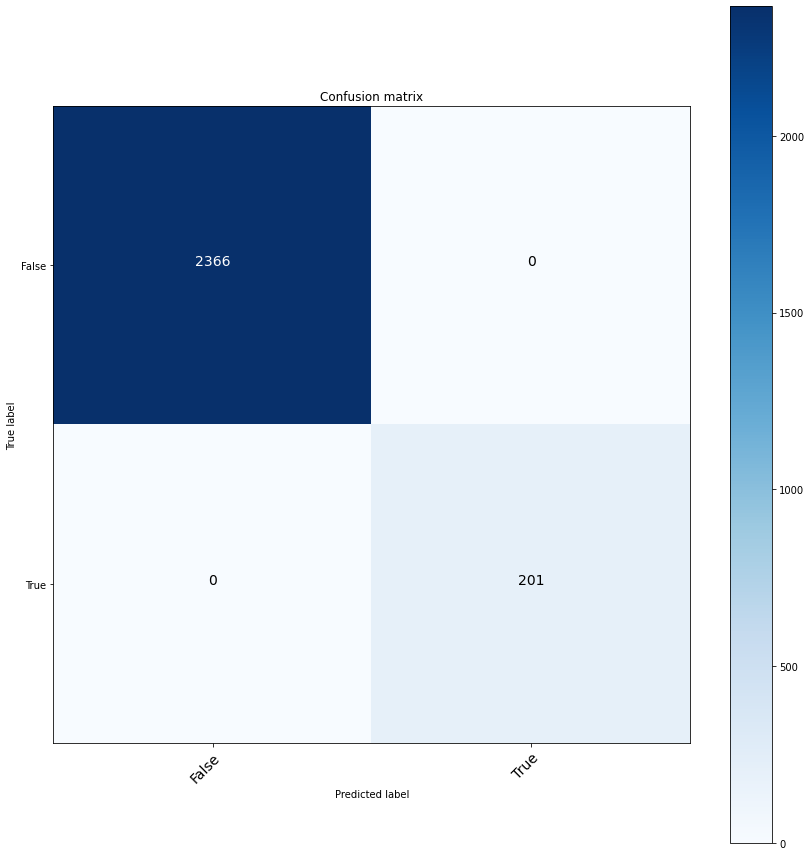

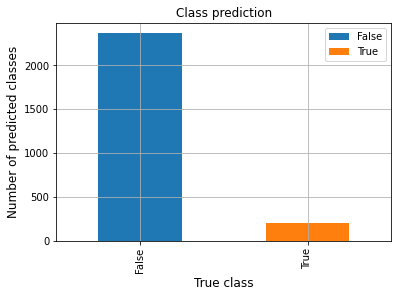

In [25]:
model = BernoulliNB()
model.fit(train_c, y_train_c)

# Predict Output
y_pred = model.predict(test_c)
y_proba = model.predict_proba(test_c)
k = 10
kf = KFold(n_splits=k, random_state=None)
# Evaluate results
results = classeval.eval(y_test_c.values.astype(bool), y_pred.astype(bool), y_proba[:,0])
result = cross_val_score(model , X, y, cv = kf)
print("Accuracy Score is ", model.score(train_c, y_train_c))
print("Avg accuracy: {}".format(result.mean()))
classeval.plot(results)

In [26]:
conf_mat = metrics.confusion_matrix(y_pred, y_test_c)
print('Accuracy state 1:', conf_mat[0, 0] / conf_mat[0, 1] * 100)
print('Accuracy state 0:', conf_mat[1, 0] / conf_mat[1, 1] * 100)

Accuracy state 1: inf
Accuracy state 0: 0.0


<ipython-input-26-4c1f3e64e363>:2: RuntimeWarning: divide by zero encountered in longlong_scalars
  print('Accuracy state 1:', conf_mat[0, 0] / conf_mat[0, 1] * 100)
